In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

In [34]:
d = 2
T = 0.05
def U(x):
    dU_x1 = (x[:, 0:1] ** 2 - 1)**2 
    for i in range(1, d):
        dU_x1 += 0.3 * (x[:, i:i+1])**2
    return dU_x1

In [ ]:
class CRYOModel(tf.keras.Model):
    def __init__(self):
        super(CRYOModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))
        self.dense2 = tf.keras.layers.Dense(64, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))
        self.dense3 = tf.keras.layers.Dense(64, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))
        self.output_lay = tf.keras.layers.Dense(1)
    
    def call(self, inputs):
        return self.output_lay(self.dense3(self.dense2(self.dense1(inputs))))

def boltzmann_weight(x, beta=1.0):
    return tf.exp(-U(x) * beta)

@tf.function
def loss(model, x, beta=0.05, lamb=1.0):

    x0 = x[:, 0]

    A = x0 < 0.25
    B = x0 > 0.75
    Om = tf.logical_not(tf.logical_or(A, B))

    x_A = tf.boolean_mask(x, A)
    x_B = tf.boolean_mask(x, B)
    x_O = tf.boolean_mask(x, Om)

    rho_A = boltzmann_weight(x_A, beta)
    rho_B = boltzmann_weight(x_B, beta)
    rho_O = boltzmann_weight(x_O, beta)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_O)
        q = model(x_O)
    grad_q = tape.gradient(q, x_O)
    del tape
    
    q_A = model(x_A)
    q_B = model(x_B)

    loss_O = tf.reduce_mean(tf.reduce_sum(grad_q**2, axis=1) * rho_O)
    loss_A = tf.reduce_mean(q_A**2 * rho_A)
    loss_B = tf.reduce_mean((1-q_B)**2 * rho_B)
    return loss_O + lamb*(loss_A + loss_B)


In [46]:
dim = 2
num_samples = 1000
samples = tf.random.uniform((num_samples, dim))

model = CRYOModel()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

epochs = 10000

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        total_loss = loss(model, samples)
    gradients = tape.gradient(total_loss, model.trainable_variables)
    del tape
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.numpy()}") 

Epoch 0, Total Loss: 1.6891237497329712
Epoch 1000, Total Loss: 0.1857941895723343
Epoch 2000, Total Loss: 0.0911124050617218
Epoch 3000, Total Loss: 0.0457083061337471
Epoch 4000, Total Loss: 0.032097697257995605
Epoch 5000, Total Loss: 0.028052929788827896
Epoch 6000, Total Loss: 0.02237103134393692
Epoch 7000, Total Loss: 0.020634330809116364
Epoch 8000, Total Loss: 0.02077879011631012
Epoch 9000, Total Loss: 0.019050799310207367


In [47]:
test = tf.random.uniform((1000, dim))
u_pred = model(test)


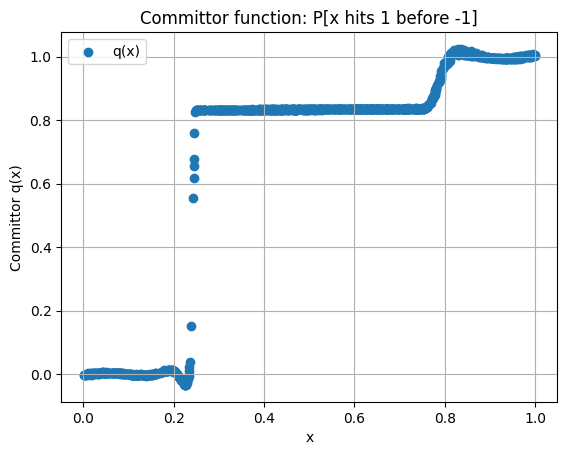

In [48]:
plt.scatter(test[:, 0], u_pred, label="q(x)")
plt.xlabel("x")
plt.ylabel("Committor q(x)")
plt.title("Committor function: P[x hits 1 before -1]")
plt.grid(True)
plt.legend()
plt.show()